In [1]:
import warnings  # suppress future warnings

import pandas as pd
import numpy as np
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional

from pandas.plotting import register_matplotlib_converters

pd.options.display.float_format = '{:.3f}'.format
register_matplotlib_converters()

# set settings for seaborn
sns.set_style(style="whitegrid", rc={"grid.color": ".9"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
title_font = {"fontname": "DejaVu Sans Mono"}

conn = psycopg2.connect("dbname = bikemi user=luca")

warnings.simplefilter(action="ignore", category=FutureWarning)


def retrieve_daily_data(connection, wide: bool = False) -> pd.DataFrame:
    query = """
        SELECT
            cdr.data_partenza,
            cdr.cluster,
            cdr.noleggi_giornalieri
        FROM bikemi_rentals.clusters_daily_rentals cdr
    """

    if not wide:
        return pd.read_sql(query, connection).rename(index=str.title)
    return (
        pd.read_sql(query, connection)
            .pivot(index="data_partenza", columns="cluster", values="noleggi_giornalieri")
            .rename(columns=str.title)
            .asfreq("D")
    )


daily_rentals: pd.DataFrame = retrieve_daily_data(conn, wide=True)

# Demand Forecasting

## Type of Forecast and Benchmark Model

Forecast can be of two types: point forecast or distributional forecast. The demand forecasts in the bike-sharing literature are point forecast and, to the best of our knowledge, do not report confidence intervals. Indeed, distributional accuracy has seldom been the goal of forecasters. As an example, forecasting competitions have been held since the late 1970s at least and are nowadays quite popular - as much as they are controversial. However, the first forecasting competition to feature measurements of the prediction interval accuracy was the so-called M4, held in 2018 <cite id="mgx7s">(Hyndman, 2020)</cite>.

When assessing the performance of a model, a benchmark needs to be established. As benchmark models we choose naïve models instead of, say, fully-fledged ARIMA (auto-regressive, integrated moving average). For the most part, authors in the literature assess the performances of their models by simply pitting them against each other <cite id="xin0g">(Hamad et al., 2021)</cite>. This is the case when more models are trained. In the case of the deep-learning branch of the literature, more sophisticated machine learning models are fitted to establish a higher benchmark for the artificial neural network to beat. Ensemble methods such as random forest regressions are usually used, as they can capture non-linear relationships  <cite id="nbbbp">(Wang &#38; Kim, 2018)</cite>.

Naïve models seems more appropriate in the context of our analysis, as we are not interested in establishing a threshold in terms of the "best" model, but also the simplest and easiest to implement. After all, it would seem quite reasonable for the policymaker/BSS manager to implement a simple moving average model to forecast the number of bikes to make available at each stall at each time of the day.

## Metrics

To evaluate the performance of the models, one or more evaluation metrics are chosen. There are a plethora of metrics which have different meanings: the literature has not yet agreed upon a specific metric or set of metrics be used specifically for forecasting bike-sharing demand, and thus some of the most common error metrics are chosen. There is only one instance where fitting time was also taken into account <cite id="ydo7j">(Hamad et al., 2021)</cite>.

In a way or another, evaluation metrics for point forecast are always a non-linear function $f(\hat{y}_t - y_y)$ of
the (sum of) prediction error, defined as $e_{t} = y_{t} - \hat{y}_{t}$. Often squares, squared roots and absolute values are involved, to return a positive value. Metrics can be of two types: scale-dependent and percentage. The difference between the two is that scale-dependent metrics cannot be used to compare performance on models trained on different datasets. A possible strategy to work around this problem is to divide the original series by its maximum value: this turns scale-dependent metrics into de-facto percentage errors, that are easier to interpret.

### Scale Dependent Metrics

The first and by far most popular error metrics are the mean absolute error (MAE) and the root mean squared error (RMSE). These are defined as such:

\begin{align}
&MAE = \frac{1}{n}\sum_{j = 1}^n \left| {{y_j} - {{\hat y}_j}} \right|\\
&RMSE=\sqrt{\frac{1}{n}\sum_{j=1}^{n}(\hat{y}_{i}-y_{i})^{2}}\\
\end{align}

These metrics are widely used, and virtually all papers in the literature employ either (MAE seems to be prevalent). Another "niche" metric is sometimes used: it is the root mean squared logarithmic error, or RMSLE. This is defined as:

\begin{align}
&RMSLE =\sqrt{\frac{1}{n}\sum_{i=1}^{N}(log(\hat{y}_{i}+1)-\log(y_{i}+1))^{2}}
\end{align}

We could track the (possibly) first usage of this metric in the field thanks to a [Kaggle competition held in 2014](https://www.kaggle.com/c/bike-sharing-demand) <cite id="9ne85">(Lozano et al., 2018)</cite>. Kaggle "was the first online platform dedicated to data mining competitions; it was established in 2010 by Australian economist Anthony Goldbloom" <cite id="zxvne">(Hyndman, 2020)</cite>. The "fundamental reason" behind RMSLE is that "the logarithmic-based calculation ensures that the errors during peak hours do not dominate the errors made during off-peak hours" <cite id="pmecw">(Lozano et al., 2018)</cite>. This is also the case for which MAE is also preferred: "We choose MAE instead of MSE because MAE is more stable to outliers and so does the case in MSLE vs. MAPE" <cite id="pnkdo">(Chen et al., 2017)</cite>.

However, it is worth noting that "A forecast method that minimises the MAE will lead to forecasts of the median, while minimising the RMSE will lead to forecasts of the mean. Consequently, the RMSE is also widely used, despite being more difficult to interpret" <cite id="j31in">(R. J. Hyndman, 2020)</cite>.

### Percentage Metrics

The advantage of percentage errors is that they are unit-free and can be used to compare performance across different datasets. This case might be of our interst, since we might want to apply the same model architectures to the different time series of the stations. The most common percentage metric employed is the Mean absolute percentage error, or MAPE, which is defined as follows:

\begin{align}
&MAPE= \frac{1}{n}\sum_{i=1}^{n}\left\vert \frac{\hat{y}_{i}-y_{i}}{y_{i}}\right\vert
\end{align}

The disadvantage of MAPE is that it may involve divisions by zero, yielding undefined terms (or, when the ground truth is close to zero, infinite error). This makes the MAPE less popular in the bike-sharing services (BSS) literature, especially with hourly forecasts as the demand will be zero during the hours when the service is not active.

To circumvent this problem, Hyndman and Koheler <cite id="2x8t3">(R. J. Hyndman &#38; Koehler, 2006)</cite> proposed to use *scaled* error metrics. Simply put, the MAE is computed and then is scaled by the *training* MAE of a simple forecast method. The scaled error $q_j$ is defined as such:

\begin{align}
q_{j} = \frac{\displaystyle e_{j}}
    {\displaystyle\frac{1}{T-1}\sum_{t=2}^T |y_{t}-y_{t-1}|}.
\end{align}

And then the mean absolute scaled error (MASE) and root mean squared scaled error (RMSSE) are defined as such:

\begin{align}
& MASE = \text{mean}(|q_{j}|) \\
& RMSSE = \sqrt{\text{mean}(q_{j}^2)}
\end{align}

MASE and RMSSE are not available in vanilla scikit-learn, as they require fitting a naive model. They are, however, available in sktime, the scikit-learn-compatible time series library developed at the Alan Turing Institute.

In [13]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_percentage_error,
)


def model_diagnostics(y_pred: pd.Series, y_true: pd.Series) -> pd.DataFrame:
    cols = ["MAE", "RMSE", "RMSLE"]

    scores = [
        mean_absolute_error(y_true, y_pred),
        mean_squared_error(y_true, y_pred, squared=True),
        mean_squared_log_error(y_true, y_pred, squared=True),
    ]
    return pd.DataFrame({"metrics": cols, "scores": scores}).round(5).T

## Cross Validation

The forecasting horizon is the number of data points that the want to forecast. The longer the horizon, the larger the prediction interval becomes; however, since we are just interested in the point forecast this does not concern us as much. There is no consensus on the literature on the kind of forecasting horizon `fh` to be used: this, of course, varies according to the frequency of the data. Sometimes, deep learning models are used to forecast the demand at the next hour, as they are intended to be later deployed as real-time applications. Since we have daily data, we shall use a 7 day forecasting horizon.

The cross-validation (CV) technique used is the sliding window, that looks like the example below:

```
|-----------------------|
| * * * * * x x x - - - |
| - * * * * * x x x - - |
| - - * * * * * x x x - |
| - - - * * * * * x x x |
```

The `*` indicate the (sliding) training set, that in our case has length 365 - to capture yearly seasonalities. The `x` represent the forecasting horizon `fh` and at each iteration the window slides by a step parameter of one. This implies more than 700 models are fit for each algorithm, on a Intel i5-5350U CPU (fitfh generation) with 1.80GHz, 4 cores (the GPU is integrated in the SoC).

To implement this cross-validation scheme we use the dedicated `sktime` function. This implies that the resulting `generator object` cannot be passed to scikit-learn's `cross_val_pred` function, that fits the estimator on each fold. Even if it did, this would not be enough, as the function does *not* compute by default the average prediction of the point. Such features are implemented by the `pmdarima` library, which works only with ARIMA models. `sktime` does not offer this capabilites, yet, but implements an `evaluate` function that returns the forecast at each interval.

We write a custom function to average the predictions and take that as the predicted value of the model. This implies that our models will be low in variance: we are de facto aggregating several weak learners into an ensemble method, dampening the variance.

In [78]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

cv_generator = SlidingWindowSplitter(fh=np.arange(1, 8),
                                     step_length=1,
                                     window_length=365
                                     )


def get_cv_predictions(evaluated_cv: pd.DataFrame) -> pd.DataFrame:
    return (
        pd.concat([evaluated_cv["y_pred"][k] for k in range(evaluated_cv.shape[0])], axis=1)
            .apply(np.mean, axis=1)
            .rename("predictions")
    )

## Naïve Forecaster

As naive forecaster, we simply choose a seasonal model with periodicity set to 7 (i.e., takes the value of the demand on the same day of the week before). We pass the model trough the cross-validation pipeline solely to get an estimate of the fitting time: to obtain the results it would be sufficient to shift the whole series by one week.

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

y = daily_rentals["Brera - 25"]
y_true = daily_rentals["Brera - 25"][365:]

naive_forecaster = NaiveForecaster(strategy="last",
                                   sp=7)  # weekly seasonal periodicity

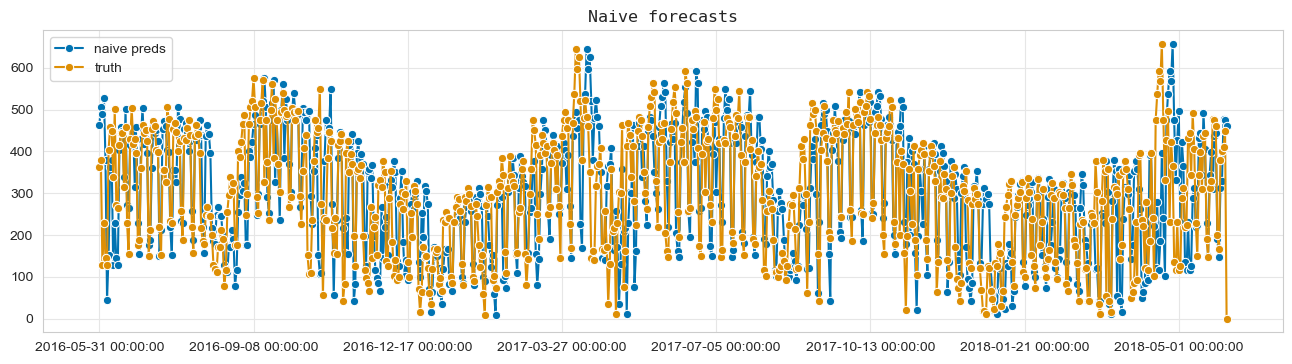

In [59]:
quick_naive_preds = pd.Series(data=daily_rentals["Brera - 25"][358:-7].values, index=y[365:].index)
naive_fig = plot_series(quick_naive_preds, y_true, labels=["naive preds", "truth"])
plt.title("Naive forecasts", **title_font)
plt.show(naive_fig)

In [14]:
naive_diagnostics = model_diagnostics(quick_naive_preds, y_true)

naive_diagnostics

,0,1,2
metrics,MAE,RMSE,RMSLE
scores,87.165,14327.643,0.438


## Univariate Time Series: Arima

ARIMA models are some of the most ubiquitous time-series algorithms. Usually, they require fine-hand, which is not feasible when forecasting multiple time series. Luckily, Hyndman and Khandakar <cite id="vred7">(R. J. Hyndman &#38; Khandakar, 2008)</cite> came up with an algoritm to automatically compute the optimal parameters, which is not the usual grid-search. This algorithm was implemented in R and then ported to Python with the `pmdarima` library <cite id="86exo">(Smith &#38; others, 2017)</cite>.

In fact, normally Auto-ARIMA would use differencing tests (like the KPSS and ADF test in the previous chapter, but also the Phillips–Perron) to determine the order of differencing `d`, if not specified, and then fit models within ranges of defined `start_p`, `max_p`, `start_q`, `max_q`. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal `P`,`D and `Q` hyperparameters`.

In order to find the best model, with the stepwise procedure the auto-ARIMA optimizes for a given information criterion, like the Akaike Information Criterion and the Bayesian Information Criterion. Simply put, the AIC and BIC are a linear function of the maximum likelihood with a correction to penalise specifications that are too complex.


In [114]:
import pmdarima as pm

y_train, y_test = model_selection.train_test_split(y, train_size=0.1)

# Fit a simple auto_arima model
autoarima = pm.auto_arima(y_train,
                          start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          d=0,  # only seasonal differencing
                          m=7,
                          start_P=1, start_Q=1,
                          max_P=5, max_Q=5,
                          D=1,
                          test="kpss",
                          information_criterion="bic",
                          trace=True,
                          seasonal=True,
                          stepwise=True,
                          error_action='trace',
                          suppress_warnings=True,
                          random_state=42)

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : BIC=1199.065, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : BIC=1149.762, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : BIC=1174.342, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[7]             : BIC=1194.517, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : BIC=1159.588, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : BIC=1151.659, Time=0.60 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : BIC=1147.470, Time=0.46 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : BIC=1144.159, Time=0.25 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : BIC=1148.124, Time=0.41 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : BIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : BIC=1203.499, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : BIC=1143.264, Time=0.31 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : BIC=1159.172, Time=0.17 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : BIC=1

The auto-ARIMA procedure suggests a SARIMA(1,0,1)(0,1,1,7), using both the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). Before fitting, let's have a look at the diagnostics. We need to verify that residuals are standardised with zero mean, and normally distributed and that are not serially correlated.

/usr/local/Caskroom/miniconda/base/envs/bikemi/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


[]

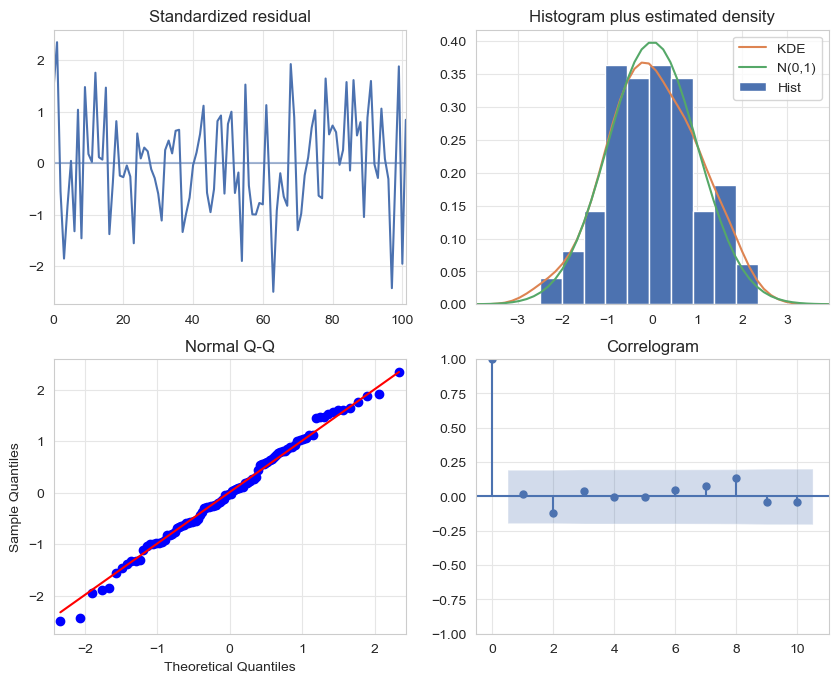

In [116]:
import warnings
warnings.filterwarnings("UserWarning")

autoarima.plot_diagnostics(figsize=(10,8))
plt.plot()

In [126]:
from pmdarima import model_selection

sliding_arima = pm.ARIMA(order=autoarima.order,
                         seasonal_order=autoarima.seasonal_order,
                         suppress_warnings=True)

pmdarima_cv = model_selection.SlidingWindowForecastCV(window_size=365,
                                                      h=14,
                                                      step=7
)

pdmarima_predictions = model_selection.cross_val_predict(sliding_arima, y,
                                                cv=pmdarima_cv, verbose=False,
                                                averaging="mean")

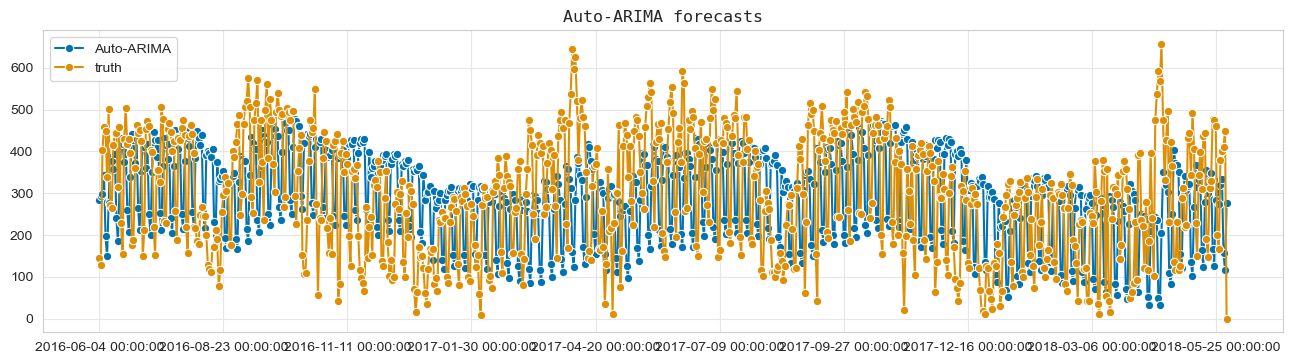

In [133]:
pmdarima_fig = plot_series(pd.DataFrame(pdmarima_predictions, index=y_true[4:].index), y_true[4:], labels=["Auto-ARIMA", "truth"])
plt.title("Auto-ARIMA forecasts", **title_font)
plt.show(pmdarima_fig)

The ARIMA model follows the trend, but does not seem to catch the sudden spikes and dips due to holidays, which echo in later observations with some delay - even if the seasonal component is just `Q=1`. Fitting time was significantly higher, so we chose to double the forecasting horizon and set the forecasting step to 7, actually fitting a bit less than half of the initial 726 models. `pmdarima`'s `cross_val_predict` already averages the results. We are not surprised to see a performance that is not stellar, but the results are actually discouraging: the model performs worse than the naive benchmark.

In [129]:
pmdarima_diagnostics = model_diagnostics(pdmarima_predictions, y_true[4:])
pmdarima_diagnostics

,0,1,2
metrics,MAE,RMSE,RMSLE
scores,158.631,35406.785,0.782


## Unvariate Time Series: Prophet

[`prophet`](https://github.com/facebook/prophet) is a time-series forecasting library developed by Meta (back when it was still called Facebook). It is also by far the most popular time series forecasting framework for Python: it has a whopping 13.4k stars on GitHub, and tops the list of the `forecasting` [topic](https://github.com/topics/forecasting) on GitHub, with more than 10k stars compared to the second runner, `sktime`. Many of the - unofficial - PyPi rankings [such as this one](https://hugovk.github.io/top-pypi-packages/) put it at over one million monthly downloads. Its lure is understandable: forecasting is as simple as importing the library and fitting a model, with little to no tweaking.

The library makes some bold claims, as it can be seen from the name. Upholding the library is a Bayesian model written in Stan, which simply decomposes a time series model into trend, season, and holiday components. In particular, Prophet can be broken down in three main features.

First, the libray supports logistic or linear growth trend, with optional linear splines (knots are referred to as “change points”) and, by default, "specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series" <cite id="4s1s2">(Taylor &#38; Letham, 2017)</cite>. Secondly, it implements Fourier series for seasonal terms, and users can also specify their own seasonalities (according to their domain knowledge), along the period and the Fourier order. Finally, Gaussian functions are used for holiday effects - making the holiday effect smoother compared to using dummies, and users can specify the country holidays they refer to. This is possible because of the Python package `holidays`, which also implements regional holidays. Via `sktime`, users can also supply a `pandas.DataFrame` with holidays that are not recorded in `holidays`. However, since the only Milanese holiday not in the national calendar is Sant'Ambrogio, on December 7, which falls just right behind the national holiday of Immacolata, and the bell curves should capture its effects. Most importantly, however, Prophet just fits a local trend, without using any lag as predictor.

According to the authors, the library purpose is to enable forecasting "at scale", that is "suitable  for  1)  a  large  number  of  people  making  forecasts,  possibly  without  training  time  series  methods;  and  2)  a  large  variety  of  forecasting  problems  with  potentially idiosyncratic features". They describe the model as "flexible enough for  a  wide  range  of  business  time  series,  yet  configurable  by  non-experts  who  may  have domain knowledge about the data generating process but little knowledge about time series models and methods". Finally, the model is designed to enable "fast" modeling for "when hundreds or even thousands of forecasts" are necessary.

This makes it both flexible and dangerous: outside its domain, i.e. highly seasonal series, Prophet models won't likely yield accurate forecasts. For example, Prophet models simply cannot be applied in the financial sector, where models are random walks and "tend to exhibit little highly profitable predictable seasonality". Nonetheless, from our previous time-series analysis it is evident that our data displays multiple seasonal patterns, as well as holiday-related patterns which cannot be explained by a dichotomic dummy variable.

In [15]:
from sktime.forecasting.fbprophet import Prophet

prophet_forecaster = Prophet(add_country_holidays={'country_name': 'Italy'},
                             daily_seasonality=False,
                             weekly_seasonality=True,
                             yearly_seasonality=True)

prophet_fit = evaluate(prophet_forecaster, cv_generator, y, return_data=True)

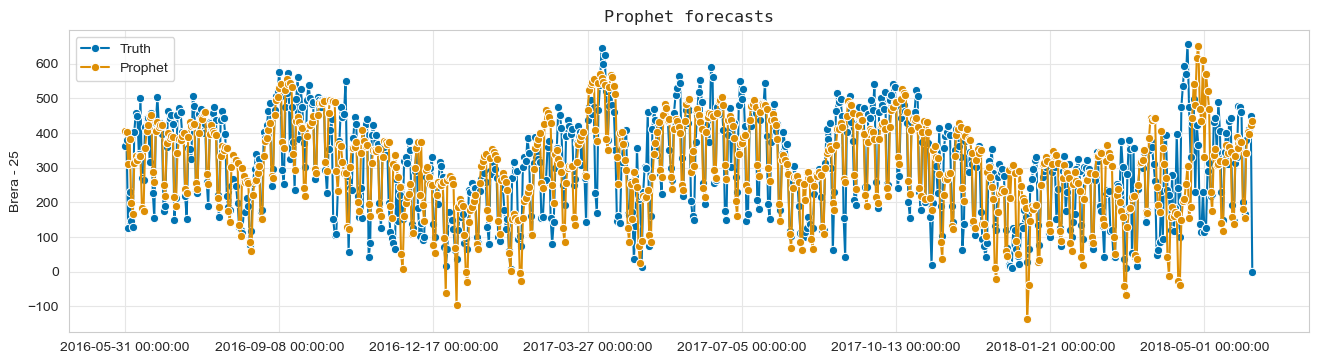

In [79]:
prophet_preds = get_cv_predictions(prophet_fit)
prophet_fig = plot_series(y_true, prophet_preds, labels=["Truth", "Prophet"])
plt.title("Prophet forecasts", **title_font)
plt.show(prophet_fig)

The model clearly captures the trend dynamics and is quite quick in capturing the sudden changes. The peaks are sometimes too smooth and there are some non-positive values that need to be replaced. This happens to less than 15 observations, but these predictions can be as low as -135 trips and, to the best of our knowledge, there is no way to enforce these limitations to the estimator.

In [82]:
def remove_negatives(data: pd.DataFrame) -> pd.DataFrame:
    data[data < 0] = 1
    return data


prophet_diagnostics = prophet_preds.pipe(remove_negatives).pipe(model_diagnostics, y_true)
prophet_diagnostics

,0,1,2
metrics,MAE,RMSE,RMSLE
scores,76.110,10678.567,0.560


<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry">Chen, P.-C., Hsieh, H.-Y., Sigalingging, X. K., Chen, Y.-R., &#38; Leu, J.-S. (2017). Prediction of Station Level Demand in a Bike Sharing System Using Recurrent Neural Networks. <i>2017 IEEE 85th Vehicular Technology Conference (VTC Spring)</i>, 1–5. https://doi.org/10.1109/VTCSpring.2017.8108575</div>

  <div class="csl-entry">Hamad, S. Y. Y., Ma, T., &#38; Antoniou, C. (2021). Analysis and Prediction of Bikesharing Traffic Flow – Citi Bike, New York. <i>2021 7th International Conference on Models and Technologies for Intelligent Transportation Systems (MT-ITS)</i>, 1–8. https://doi.org/10.1109/MT-ITS49943.2021.9529290</div>

  <div class="csl-entry">Hyndman, R., &#38; Athanasopoulos, G. (2021). <i>Forecasting: Principles and Practice</i>. https://research.monash.edu/en/publications/forecasting-principles-and-practice-3</div>

  <div class="csl-entry">Hyndman, R. J. (2020). A brief history of forecasting competitions. <i>International Journal of Forecasting</i>, <i>36</i>(1), 7–14. https://doi.org/10.1016/j.ijforecast.2019.03.015</div>

  <div class="csl-entry">Hyndman, R. J., &#38; Khandakar, Y. (2008). Automatic Time Series Forecasting: The forecast Package for R. <i>Journal of Statistical Software</i>, <i>27</i>, 1–22. https://doi.org/10.18637/jss.v027.i03</div>

  <div class="csl-entry">Hyndman, R. J., &#38; Koehler, A. B. (2006). Another look at measures of forecast accuracy. <i>International Journal of Forecasting</i>, <i>22</i>(4), 679–688. https://doi.org/10.1016/j.ijforecast.2006.03.001</div>

  <div class="csl-entry">Lozano, Á., De Paz, J. F., Villarrubia González, G., Iglesia, D. H. D. L., &#38; Bajo, J. (2018). Multi-Agent System for Demand Prediction and Trip Visualization in Bike Sharing Systems. <i>Applied Sciences</i>, <i>8</i>(1), 67. https://doi.org/10.3390/app8010067</div>

  <div class="csl-entry">Smith, T. G., &#38; others. (2017). <i>pmdarima</i>. http://www.alkaline-ml.com/pmdarima</div>

  <div class="csl-entry">Taylor, S. J., &#38; Letham, B. (2017). <i>Forecasting at scale</i> (e3190v2). PeerJ Inc. https://doi.org/10.7287/peerj.preprints.3190v2</div>

  <div class="csl-entry">Wang, B., &#38; Kim, I. (2018). Short-term prediction for bike-sharing service using machine learning. <i>Transportation Research Procedia</i>, <i>34</i>, 171–178. https://doi.org/10.1016/j.trpro.2018.11.029</div>

</div>
<!-- BIBLIOGRAPHY END -->